# <center>Deepfake Detection</center>

### Chukwudi Udoka, Denny Liang, Michael Salamon, Ravid Rahman

##### CSC 59866 Senior Project II - Applied Machine Learning
##### The City College of New York

## TABLE OF CONTENTS:
* [Problem Statement](#part-0)
* [Exploratory Data Analysis](#part-1)
* [Modeling](#part-2)
    * [Deepfake Detection Main](#part-2a)
    * [Eye Blink Detection](#part-2b)
    * [Beard Detection](#part-2c)
    * [Glasses Detection](#part-2d)
* [Results](#part-3)
    * [DFD Model Accuracy](#part-3a)
    * [Eye Blink Model Accuracy](#part-3b)
    * [Beard Model Accuracy](#part-3c)
    * [Glasses Model Accuracy](#part-3d)
* [Impact](#part-4a)
* [Video References](#part-4b)

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import statistics

# PROBLEM STATEMENT <a id="part-0"></a>

Deepfakes are computer generated videos of people that give the illusion of authenticity. The most common deepfake replaces a victims face with someone elses face. Deepfakes can be benign, such as switching celebrity faces for entertainment, and in cinema, particularly for ageing affects. However, since the majority of deepfakes don't disclose that it's real, it can have negative effects on the future of society. Video evidence can no longer be considered genuine.  

The target audience for our deepfake detection application is lawyers. Rather than relying on one deepfake detection output, our application returns multiple outputs. In the courtroom, the critical eye of a lawyer can make his/her case for ambiguous videos. Lawyers can interpret the models outputs as they see fit.

# EXPLORATORY DATA ANALYSIS <a id="part-1"></a>

Since the main source of data for this project is [Meta's Deepfake Detection Challenge](https://www.kaggle.com/c/deepfake-detection-challenge) videos, there isn't a lot of meta-data to explore. The provided sample set (training videos + testing videos = 4GB) is 800 videos of paid actors doing regular activities. The quality of deepfakes range from choppy/blurry to very smooth/realistic. It is important to note that although the dataset had instances of auditory deepfakes, this project focused only on the classification of visual deepfakes.

# MODELING <a id="part-2"></a>

In [2]:
# Set up all dataframes

# DFD
DFD_dim_df = pd.read_csv("Stored Test Results/dimvideos.csv", header=0)
DFD_test_ori_df = pd.read_csv("Stored Test Results/deepfake_test_original.csv", header=0)
DFD_test_upd_df = pd.read_csv("Stored Test Results/deepfake_test_updated.csv", header=0)

# Eye Blink
eyes_df = pd.read_csv("Stored Test Results/eyeblinks.csv", header=0)
eyes_unknown_df = pd.read_csv("Stored Test Results/eyeblinks_unknown.csv", header=0)

# Beard
beard_df = pd.read_csv("Stored Test Results/beards.csv", header=0)

# Glasses
shades_df = pd.read_csv("Stored Test Results/sunglasses_shades.csv", header=0)
glasses_df = pd.read_csv("Stored Test Results/sunglasses_glasses.csv", header=0)
glasses_crop_df = pd.read_csv("Stored Test Results/sunglasses_glasses_crop.csv", header=0)

## Deepfake Detection Main <a id="part-2a"></a>

Our main Deepfake Detection (DFD) Model adhered to the rules of the competition: the model was only trained using videos provided by the competition. Below is an example of what the videos looked like. The model uses helper functions for still-frame extraction. In the case that there is more than one person in a video, helper functions detect unique faces and choose one unique face, the one of higher quality, to remain consistant in output score. Model weights were saved onto file. Outputs ranged from 0.01-0.99, whereby higher scores indicate greater confidence the video is a deepfake. Transfer learned ResNeXt model.  

<div>
<img src="Figures/Train_Dataset.png" width="800"/>
</div>

## Eye Blink Detection <a id="part-2b"></a>

The Eye Blink model transfer learned a VGG16() model and trained with a 2100 image dataset, as seen below. The images were extracted from various videos, some from the Kaggle dataset and others from YouTube. Binary classification of open eyes or closed eyes. For the training set, each frame was manually classified. After we trained the model, weights were saved onto file.  

<div>
<img src="Figures/Eyeblink_model_Dataset.png" width="800"/>
</div>

Although the eye blink model returns one of two classifications, we created a function called blink_on_video() which returns 2 additional classifications. In total, there are 4 classifications:  
\[**Missing**, **Unknown**, **Open Eyes**, **Closed Eyes**\]  

<div>
<img src="Figures/blink_docstring.png" width="500"/>
</div>

First, blink_on_video() extracts frames from the video. The expected total frames extracted from the video is total=floor(fps×sec). fps is one of blink_on_video()'s arguments, the user determines the rate of frames extracted per second. sec is the entire video duration. However, if a person isn't detected for the entire video, **Missing**=(total-actual)/total.  

Each frame of the video needs to be cropped before the eye blink model makes a prediction. This cropped image only contains the persons face. Originally, if blink_on_video() failed to crop the current frame, the model would make it's prediction using the most recent cropped image, from a previous frame. This is inaccurate since it would return the exact same classification as the previous frame. To account for this scenario, we updated blink_on_video() to classify the current frame as **Unknown** if it couldn't be cropped.

## Beard Detection <a id="part-2c"></a>

DeepFace model from Meta. No training required. Detect the age and gender of a person in an image.  

<div>
<img src="Figures/deepface.png" width="200"/>
</div>

## Glasses Detection <a id="part-2d"></a>

Default VGG16() model provides the top 5 image classifications from [1000's of potential labels](https://image-net.org/challenges/LSVRC/2014/browse-synsets#:~:text=n04356056%3A%20sunglasses%2C%20dark%20glasses%2C%20shades). In particular, we're interested in the label 'n04356056' which represents 'sunglasses, dark glasses, shades'. We'll assume this can detect both shades and regular glasses.

# RESULTS <a id="part-3"></a>

## DFD Model Accuracy <a id="part-3a"></a>

One of our earliest speculations was that the model would detect a lot of false positives for authentic videos that had poor lighting, shadows on the face exc. We tested this out on 10, 10 second videos from YouTube (as shown below) that fell in this category.  

<div>
<img src="Figures/Dim_Dataset.png" width="800"/>
</div>

Below were the results:

In [3]:
DFD_dim_df

,Name,Size (MB),Predict (%)
0,dim01.mp4,14.14,61.54
1,dim02.mp4,5.24,33.78
2,dim03.mp4,1.72,1.49
3,dim04.mp4,3.50,51.20
4,dim05.mp4,1.57,25.05
5,dim06.mp4,0.52,12.51
6,dim07.mp4,1.42,1.48
7,dim08.mp4,1.04,46.66
8,dim09.mp4,1.38,24.99
9,dim10.mp4,0.97,28.44


In [4]:
print("The percent of videos that were misclassified as deepfakes was", len(DFD_dim_df[DFD_dim_df["Predict (%)"]>50.00])/10*100,"%")

The percent of videos that were misclassified as deepfakes was 20.0 %


Since there were false positives 20% of the time, with low confidence of 61.54% and 51.20%, we didn't implement video brightness methods.

Moving on to more significant testing, we watched the 400 video testing set provided by Kaggle and manually labeled each video as either Deepfake (1), Real (0), or Not sure (-1).

In [5]:
DFD_test_ori_df

,Name,Length (bytes),CreationTime,Real Labels
0,aassnaulhq.mp4,6987195,12/10/2019 2:21,0.0
1,aayfryxljh.mp4,10114027,12/10/2019 2:21,0.0
2,acazlolrpz.mp4,4098352,12/10/2019 2:21,1.0
3,adohdulfwb.mp4,3736581,12/10/2019 2:21,0.0
4,ahjnxtiamx.mp4,4259685,12/10/2019 2:21,1.0
...,...,...,...,...
395,ztyvglkcsf.mp4,3272599,12/10/2019 2:25,0.0
396,zuwwbbusgl.mp4,3217523,12/10/2019 2:25,0.0
397,zxacihctqp.mp4,4642008,12/10/2019 2:25,0.0
398,zyufpqvpyu.mp4,5033745,12/10/2019 2:25,-1.0


In [6]:
print(len(DFD_test_ori_df[DFD_test_ori_df['Real Labels']==1.0]))
print(len(DFD_test_ori_df[DFD_test_ori_df['Real Labels']==0.0]))
print(len(DFD_test_ori_df[DFD_test_ori_df['Real Labels']==-1.0]))

110
251
39


In [7]:
DFD_test_ori_df['Real Labels'] = DFD_test_ori_df['Real Labels'].fillna(2)

In [8]:
DFD_test_ori_df

,Name,Length (bytes),CreationTime,Real Labels
0,aassnaulhq.mp4,6987195,12/10/2019 2:21,0.0
1,aayfryxljh.mp4,10114027,12/10/2019 2:21,0.0
2,acazlolrpz.mp4,4098352,12/10/2019 2:21,1.0
3,adohdulfwb.mp4,3736581,12/10/2019 2:21,0.0
4,ahjnxtiamx.mp4,4259685,12/10/2019 2:21,1.0
...,...,...,...,...
395,ztyvglkcsf.mp4,3272599,12/10/2019 2:25,0.0
396,zuwwbbusgl.mp4,3217523,12/10/2019 2:25,0.0
397,zxacihctqp.mp4,4642008,12/10/2019 2:25,0.0
398,zyufpqvpyu.mp4,5033745,12/10/2019 2:25,-1.0


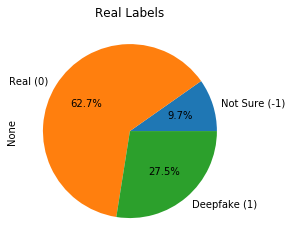

In [9]:
DFD_test_ori_df[['Real Labels']].value_counts(sort=False).plot.pie(labels=('Not Sure (-1)','Real (0)','Deepfake (1)','NaN'),autopct='%1.1f%%')
plt.title('Real Labels')
plt.show()

Due to time constraints, only 80% of the dataset was manually labelled. Ignoring about 8.0% of the dataset that was ambigious, approximately 290 videos were taken for testing. Only 100 of these videos were used for testing b/c of slow evaluations.

Below are the evaluation results for the DFD model. Later, we'll evaluate the outputs from other models for accuracy. For now, we'll see if we can use these outputs from the 3 user trust models to deliver correct deepfake detection predictions where DFD failed.

In [10]:
DFD_test_upd_df

,Name,Real Labels,DFD (15 FPS),DFD (12 FPS),DFD (09 FPS),DFD (06 FPS),DFD (03 FPS),DFD (01 FPS),Blink (15 FPS) 0,Blink (15 FPS) 1,Blink (15 FPS) 2,Blink (15 FPS) 3,Beard: Age,Beard: Gender,Glasses
0,aassnaulhq.mp4,0,0.529217,0.536800,0.536746,0.550164,0.560346,0.548783,0.0,48.67,5.33,46.00,43.0,Man,9.12
1,aayfryxljh.mp4,0,0.005199,0.005302,0.004884,0.004623,0.003173,0.017791,0.0,0.00,88.67,11.33,47.0,Man,0.00
2,acazlolrpz.mp4,1,0.733870,0.722285,0.727390,0.749724,0.756411,0.740346,0.0,14.00,9.33,76.67,40.0,Man,0.00
3,adohdulfwb.mp4,0,0.088653,0.086411,0.090924,0.099174,0.125159,0.054809,0.0,0.00,92.67,7.33,33.0,Woman,0.00
4,ahjnxtiamx.mp4,1,0.903451,0.910799,0.885521,0.902039,0.924152,0.975536,0.0,0.00,58.67,41.33,42.0,Man,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,uqvxjfpwdo.mp4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,usqqvxcjmg.mp4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,uubgqnvfdl.mp4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,uvrzaczrbx.mp4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Remove all rows w/ NaNs... videos that didn't get tested
DFD_test_upd_df=DFD_test_upd_df.dropna(thresh=13)
DFD_test_upd_df

,Name,Real Labels,DFD (15 FPS),DFD (12 FPS),DFD (09 FPS),DFD (06 FPS),DFD (03 FPS),DFD (01 FPS),Blink (15 FPS) 0,Blink (15 FPS) 1,Blink (15 FPS) 2,Blink (15 FPS) 3,Beard: Age,Beard: Gender,Glasses
0,aassnaulhq.mp4,0,0.529217,0.536800,0.536746,0.550164,0.560346,0.548783,0.0,48.67,5.33,46.00,43.0,Man,9.12
1,aayfryxljh.mp4,0,0.005199,0.005302,0.004884,0.004623,0.003173,0.017791,0.0,0.00,88.67,11.33,47.0,Man,0.00
2,acazlolrpz.mp4,1,0.733870,0.722285,0.727390,0.749724,0.756411,0.740346,0.0,14.00,9.33,76.67,40.0,Man,0.00
3,adohdulfwb.mp4,0,0.088653,0.086411,0.090924,0.099174,0.125159,0.054809,0.0,0.00,92.67,7.33,33.0,Woman,0.00
4,ahjnxtiamx.mp4,1,0.903451,0.910799,0.885521,0.902039,0.924152,0.975536,0.0,0.00,58.67,41.33,42.0,Man,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,gochxzemmq.mp4,0,0.198241,0.201587,0.214688,0.187394,0.214700,0.312123,0.0,0.00,40.67,59.33,51.0,Man,16.32
96,gpsxfxrjrr.mp4,0,0.118936,0.112795,0.121392,0.113125,0.105131,0.115694,0.0,0.00,22.67,77.33,35.0,Man,0.00
97,gqnaxievjx.mp4,0,0.409736,0.408417,0.413323,0.413710,0.410077,0.437941,0.0,96.67,2.00,1.33,46.0,Man,0.00
98,gunamloolc.mp4,1,0.927019,0.926221,0.930175,0.924442,0.921965,0.905910,0.0,86.67,0.00,13.33,38.0,Man,0.00


In [12]:
DFD_test_upd_df[DFD_test_upd_df['Beard: Gender'].isna()]

,Name,Real Labels,DFD (15 FPS),DFD (12 FPS),DFD (09 FPS),DFD (06 FPS),DFD (03 FPS),DFD (01 FPS),Blink (15 FPS) 0,Blink (15 FPS) 1,Blink (15 FPS) 2,Blink (15 FPS) 3,Beard: Age,Beard: Gender,Glasses
9,aqrsylrzgi.mp4,0,0.517734,0.521072,0.524206,0.523282,0.528277,0.524681,0.0,100.0,0.0,0.0,-1.0,NaN,-1.0
15,bjyaxvggle.mp4,1,0.939367,0.938263,0.938137,0.932468,0.921637,0.921749,0.0,100.0,0.0,0.0,-1.0,NaN,-1.0
61,eqslzbqfea.mp4,0,0.421258,0.409462,0.401789,0.408878,0.415425,0.441976,0.0,100.0,0.0,0.0,-1.0,NaN,-1.0


During testing, if a video didn't have a single open eye or closed eye frame, 'Beard: Age' + 'Glasses' were assigned values of -1. Under the same case, we assigned the string "N/A" for 'Beard: Gender'... it appears it's being recognized as a NaN here. These rows should be dropped from the dataframe.

In [13]:
DFD_test_upd_df=DFD_test_upd_df[DFD_test_upd_df['Beard: Gender'].notna()]
DFD_test_upd_df=DFD_test_upd_df.reset_index()
DFD_test_upd_df

,index,Name,Real Labels,DFD (15 FPS),DFD (12 FPS),DFD (09 FPS),DFD (06 FPS),DFD (03 FPS),DFD (01 FPS),Blink (15 FPS) 0,Blink (15 FPS) 1,Blink (15 FPS) 2,Blink (15 FPS) 3,Beard: Age,Beard: Gender,Glasses
0,0,aassnaulhq.mp4,0,0.529217,0.536800,0.536746,0.550164,0.560346,0.548783,0.0,48.67,5.33,46.00,43.0,Man,9.12
1,1,aayfryxljh.mp4,0,0.005199,0.005302,0.004884,0.004623,0.003173,0.017791,0.0,0.00,88.67,11.33,47.0,Man,0.00
2,2,acazlolrpz.mp4,1,0.733870,0.722285,0.727390,0.749724,0.756411,0.740346,0.0,14.00,9.33,76.67,40.0,Man,0.00
3,3,adohdulfwb.mp4,0,0.088653,0.086411,0.090924,0.099174,0.125159,0.054809,0.0,0.00,92.67,7.33,33.0,Woman,0.00
4,4,ahjnxtiamx.mp4,1,0.903451,0.910799,0.885521,0.902039,0.924152,0.975536,0.0,0.00,58.67,41.33,42.0,Man,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,95,gochxzemmq.mp4,0,0.198241,0.201587,0.214688,0.187394,0.214700,0.312123,0.0,0.00,40.67,59.33,51.0,Man,16.32
93,96,gpsxfxrjrr.mp4,0,0.118936,0.112795,0.121392,0.113125,0.105131,0.115694,0.0,0.00,22.67,77.33,35.0,Man,0.00
94,97,gqnaxievjx.mp4,0,0.409736,0.408417,0.413323,0.413710,0.410077,0.437941,0.0,96.67,2.00,1.33,46.0,Man,0.00
95,98,gunamloolc.mp4,1,0.927019,0.926221,0.930175,0.924442,0.921965,0.905910,0.0,86.67,0.00,13.33,38.0,Man,0.00


In [14]:
# Compare all of the FPS columns w/ the 'Real Labels' columns.
# If FPS has a value greater than 0.5 and 'Real Labels' has a value of 1, prediction is correct.
# Otherwise, it's an invalid prediction.
# Calculate the percent of correct rows for each FPS and display the results in a bar graph.

In [15]:
DFD_FPS_results_df = DFD_test_upd_df[['Real Labels','DFD (15 FPS)', 'DFD (12 FPS)', 
                                      'DFD (09 FPS)', 'DFD (06 FPS)','DFD (03 FPS)', 
                                      'DFD (01 FPS)']]

In [16]:
def to_bool(x):
    if x > 0.5:
        return 1
    else:
        return 0

DFD_FPS_results_df['DFD (15 FPS) Bool'] = DFD_FPS_results_df['DFD (15 FPS)'].apply(lambda x: to_bool(x))
DFD_FPS_results_df['DFD (12 FPS) Bool'] = DFD_FPS_results_df['DFD (12 FPS)'].apply(lambda x: to_bool(x))
DFD_FPS_results_df['DFD (09 FPS) Bool'] = DFD_FPS_results_df['DFD (09 FPS)'].apply(lambda x: to_bool(x))
DFD_FPS_results_df['DFD (06 FPS) Bool'] = DFD_FPS_results_df['DFD (06 FPS)'].apply(lambda x: to_bool(x))
DFD_FPS_results_df['DFD (03 FPS) Bool'] = DFD_FPS_results_df['DFD (03 FPS)'].apply(lambda x: to_bool(x))
DFD_FPS_results_df['DFD (01 FPS) Bool'] = DFD_FPS_results_df['DFD (01 FPS)'].apply(lambda x: to_bool(x))

<ipython-input-16-131bc17a81b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DFD_FPS_results_df['DFD (15 FPS) Bool'] = DFD_FPS_results_df['DFD (15 FPS)'].apply(lambda x: to_bool(x))
<ipython-input-16-131bc17a81b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DFD_FPS_results_df['DFD (12 FPS) Bool'] = DFD_FPS_results_df['DFD (12 FPS)'].apply(lambda x: to_bool(x))
<ipython-input-16-131bc17a81b4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [17]:
# Compare each bool column with the real labels; 1 if match, 0 if do not match

DFD_FPS_results_df['DFD (15 FPS) Score'] = np.where(DFD_FPS_results_df["Real Labels"] == DFD_FPS_results_df["DFD (15 FPS) Bool"], True, False)
DFD_FPS_results_df['DFD (12 FPS) Score'] = np.where(DFD_FPS_results_df["Real Labels"] == DFD_FPS_results_df["DFD (12 FPS) Bool"], True, False)
DFD_FPS_results_df['DFD (09 FPS) Score'] = np.where(DFD_FPS_results_df["Real Labels"] == DFD_FPS_results_df["DFD (09 FPS) Bool"], True, False)
DFD_FPS_results_df['DFD (06 FPS) Score'] = np.where(DFD_FPS_results_df["Real Labels"] == DFD_FPS_results_df["DFD (06 FPS) Bool"], True, False)
DFD_FPS_results_df['DFD (03 FPS) Score'] = np.where(DFD_FPS_results_df["Real Labels"] == DFD_FPS_results_df["DFD (03 FPS) Bool"], True, False)
DFD_FPS_results_df['DFD (01 FPS) Score'] = np.where(DFD_FPS_results_df["Real Labels"] == DFD_FPS_results_df["DFD (01 FPS) Bool"], True, False)


<ipython-input-17-14b785d68f2e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DFD_FPS_results_df['DFD (15 FPS) Score'] = np.where(DFD_FPS_results_df["Real Labels"] == DFD_FPS_results_df["DFD (15 FPS) Bool"], True, False)
<ipython-input-17-14b785d68f2e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DFD_FPS_results_df['DFD (12 FPS) Score'] = np.where(DFD_FPS_results_df["Real Labels"] == DFD_FPS_results_df["DFD (12 FPS) Bool"], True, False)


In [18]:
DFD_FPS_eval_df = DFD_FPS_results_df[['DFD (15 FPS) Score','DFD (12 FPS) Score', 'DFD (09 FPS) Score', 
                                      'DFD (06 FPS) Score','DFD (03 FPS) Score', 'DFD (01 FPS) Score']].sum()
 
DFD_FPS_eval_df =  pd.DataFrame(DFD_FPS_eval_df/len(DFD_FPS_results_df))*100
DFD_FPS_eval_df = DFD_FPS_eval_df.sort_values(by = 0)
DFD_FPS_eval_df = DFD_FPS_eval_df.T.round(2)

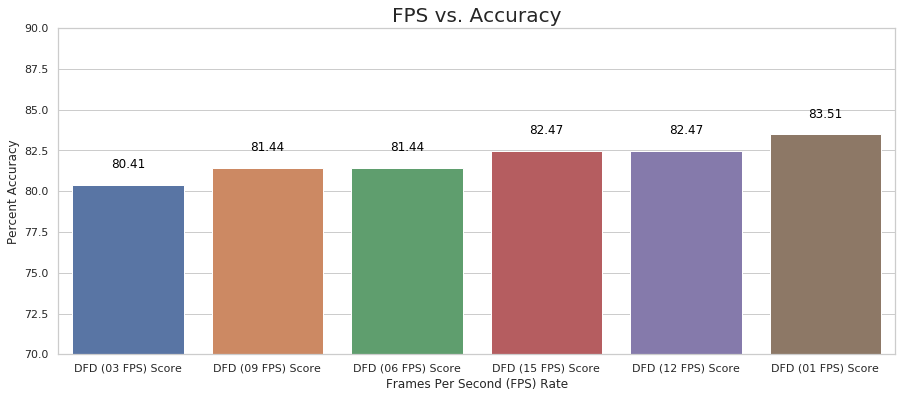

In [19]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.ylim(70, 90)
g = sns.barplot(data=DFD_FPS_eval_df)
g.set_xlabel("Frames Per Second (FPS) Rate", fontsize = 12);
g.set_ylabel("Percent Accuracy", fontsize = 12);
g.set_title("FPS vs. Accuracy", fontsize = 20);
ax=g
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 20),
                textcoords='offset points')

Now lets see if the other 3 models can help help us to further improve the accuracy. We will look at (01 FPS) for all incorrect predictions since it appears to have the highest accuracy (although negligable from 15 FPS).

In [20]:
DFD_FPS_01_incorrect_df = DFD_FPS_results_df[DFD_FPS_results_df['DFD (01 FPS) Score'] == False][['Real Labels', 'DFD (01 FPS)', 'DFD (01 FPS) Score']]

In [21]:
DFD_test_upd_df_dep = DFD_test_upd_df[['Blink (15 FPS) 0', 'Blink (15 FPS) 1', 'Blink (15 FPS) 2', 
                                        'Blink (15 FPS) 3', 'Beard: Age', 'Beard: Gender', 'Glasses']]

In [22]:
DFD_test_upd_df_dep.head()

,Blink (15 FPS) 0,Blink (15 FPS) 1,Blink (15 FPS) 2,Blink (15 FPS) 3,Beard: Age,Beard: Gender,Glasses
0,0.0,48.67,5.33,46.00,43.0,Man,9.12
1,0.0,0.00,88.67,11.33,47.0,Man,0.00
2,0.0,14.00,9.33,76.67,40.0,Man,0.00
3,0.0,0.00,92.67,7.33,33.0,Woman,0.00
4,0.0,0.00,58.67,41.33,42.0,Man,0.00


In [23]:
DFD_FPS_01_incorrect_df=DFD_FPS_01_incorrect_df.merge(DFD_test_upd_df_dep, how = 'left', left_index=True, right_index=True)
DFD_FPS_01_incorrect_df

,Real Labels,DFD (01 FPS),DFD (01 FPS) Score,Blink (15 FPS) 0,Blink (15 FPS) 1,Blink (15 FPS) 2,Blink (15 FPS) 3,Beard: Age,Beard: Gender,Glasses
0,0,0.548783,False,0.00,48.67,5.33,46.00,43.0,Man,9.12
13,0,0.525161,False,0.00,84.67,2.67,12.67,44.0,Man,10.79
24,0,0.843165,False,28.00,50.67,5.33,16.00,44.0,Man,0.00
33,0,0.525080,False,22.67,41.33,23.33,12.67,36.0,Woman,0.00
34,0,0.610142,False,1.33,78.00,18.67,2.00,39.0,Man,0.00
37,0,0.671702,False,18.67,22.67,5.33,53.33,45.0,Man,0.00
39,0,0.648923,False,0.00,0.00,97.33,2.67,40.0,Man,0.00
45,0,0.665099,False,0.00,2.00,14.67,83.33,43.0,Man,20.96
47,0,0.572551,False,0.00,0.00,90.67,9.33,36.0,Man,51.05
48,0,0.663132,False,59.33,12.67,19.33,8.67,36.0,Man,0.00


Lets average the columns to obtain intervals for which we can use the other 3 model outputs upon incorrect predictions of DFD. These incorrect predictions from the model aren't the most concerning since the confidence in deepfake prediction is low (ranges from 0.525 to 0.69, except for one row that has 0.84). Nonetheless, lets obtain our averages for eye blinks... our intervals for deepfake detection w/ eyeblink will be anything greater than or equal to the averages.

In [24]:
print("The avg for Missing frames is:", round(DFD_FPS_01_incorrect_df['Blink (15 FPS) 0'].mean(),2))
print("The avg for Unknown frames is:", round(DFD_FPS_01_incorrect_df['Blink (15 FPS) 1'].mean(),2))
print("The avg ratio for open eyes to closed eyes is:", 
      round(DFD_FPS_01_incorrect_df['Blink (15 FPS) 2'].mean()/DFD_FPS_01_incorrect_df['Blink (15 FPS) 3'].mean(),2))

The avg for Missing frames is: 13.33
The avg for Unknown frames is: 34.42
The avg ratio for open eyes to closed eyes is: 1.17


The outputs from Beard and Glasses can be used for deepfake detection if it has a 20> y.o male and it predicts glasses on the face (prediction score > 0).

Now, lets construct a boolean statement to slice the dataframe to find out how much we can improve the original accuracy of 83.51% from the DFD (FPS 01) model by using the 3 additional models.

In [25]:
other_models_detect=DFD_FPS_01_incorrect_df[(((DFD_FPS_01_incorrect_df['Blink (15 FPS) 0']>=13.33) | 
                        (DFD_FPS_01_incorrect_df['Blink (15 FPS) 1']>=34.42)) &
                        ((DFD_FPS_01_incorrect_df['Blink (15 FPS) 2']/DFD_FPS_01_incorrect_df['Blink (15 FPS) 3'])<=1.37) &
                        ((DFD_FPS_01_incorrect_df['Blink (15 FPS) 2']/DFD_FPS_01_incorrect_df['Blink (15 FPS) 3'])>=0.97))
                        |
                        ((DFD_FPS_01_incorrect_df['Beard: Age']>=20) & 
                         (DFD_FPS_01_incorrect_df['Beard: Gender']=="Man") &
                         (DFD_FPS_01_incorrect_df['Glasses']>0))]
other_models_detect

,Real Labels,DFD (01 FPS),DFD (01 FPS) Score,Blink (15 FPS) 0,Blink (15 FPS) 1,Blink (15 FPS) 2,Blink (15 FPS) 3,Beard: Age,Beard: Gender,Glasses
0,0,0.548783,False,0.00,48.67,5.33,46.00,43.0,Man,9.12
13,0,0.525161,False,0.00,84.67,2.67,12.67,44.0,Man,10.79
45,0,0.665099,False,0.00,2.00,14.67,83.33,43.0,Man,20.96
47,0,0.572551,False,0.00,0.00,90.67,9.33,36.0,Man,51.05
70,0,0.533819,False,0.00,0.00,24.00,76.00,31.0,Man,6.86
80,0,0.618446,False,29.33,29.33,22.67,18.67,35.0,Man,0.00
85,0,0.689943,False,52.00,24.67,13.33,10.00,43.0,Man,0.00


In [26]:
print("The original accuracy was", DFD_FPS_eval_df['DFD (01 FPS) Score'].iloc[0], 
      "%. This means it was", round((DFD_FPS_eval_df['DFD (01 FPS) Score'].iloc[0]/100)*len(DFD_test_upd_df)), 
      f"correct rows out of the total {len(DFD_test_upd_df)}.")

new_df_acc=round((math.floor((DFD_FPS_eval_df['DFD (01 FPS) Score'].iloc[0]/100)*len(DFD_test_upd_df))
                  +len(other_models_detect))/len(DFD_test_upd_df),4)*100
print("Since we correctly predicted", len(other_models_detect), "rows, the new accuracy is", new_df_acc,"%.")

print("Improvement of", round(new_df_acc-DFD_FPS_eval_df['DFD (01 FPS) Score'].iloc[0],2), "%")

The original accuracy was 83.51 %. This means it was 81 correct rows out of the total 97.
Since we correctly predicted 7 rows, the new accuracy is 90.72 %.
Improvement of 7.21 %


## Eye Blink Model Accuracy <a id="part-3b"></a>

Chose videos that were mostly people speaking directly to the camera... the face is close enough to see the eyes clearly. 15 FPS * 10 second videos * 10 videos = 1500 image Testing set. Screenshots from each video are shown below.  

<div>
<img src="Figures/Eyeblink_dataset.png" width="800"/>
</div>

In [27]:
eyes_df

,Name,Size (MB),Race,Gender,Open (%),Closed (%),Total Frames,Wrong Open Frames,Wrong Closed Frames
0,blink01.mp4,7.11,White,M,86.00,14.00,150,5,6
1,blink02.mp4,3.21,White,M,20.67,79.33,150,0,78
2,blink03.mp4,2.75,White,F,83.33,16.67,150,3,12
3,blink04.mp4,1.76,Non-White,M,92.67,7.33,150,3,10
4,blink05.mp4,12.86,White,M,84.67,15.33,150,8,13
5,blink06.mp4,7.79,Non-White,M,27.33,72.67,150,6,81
6,blink07.mp4,3.97,Non-White,F,68.00,32.00,150,3,7
7,blink08.mp4,1.73,White,F,99.33,0.67,150,0,0
8,blink09.mp4,3.01,White,M,92.00,8.00,150,14,0
9,blink10.mp4,1.97,Non-White,F,83.33,16.67,150,0,15


On average, a video of a person will have 'Open Eyes' frames 85%-90% of the time. The model could've easily overfit to classify 100% of frames as 'Open Eyes'. From the *Open (%)* column, we see that is not the case.

In [28]:
print(round(len(eyes_df[eyes_df['Wrong Closed Frames']>eyes_df['Wrong Open Frames']]),2)/10*100,"%")

80.0 %


For 80% of videos, the model was more likely to incorrectly classify frames as 'Closed' than incorrectly classify frames as 'Open'.

In [29]:
print(round(eyes_df['Wrong Closed Frames'].mean()/eyes_df['Wrong Open Frames'].mean(),2))

5.29


On average, for every 5 frames incorrectly predicted as 'Closed', 1 frame is incorrectly predicted as 'Open'.

In [30]:
open_eyes_frames=[]
closed_eyes_frames=[]

for i in range(0,len(eyes_df)):
    temp=eyes_df['Open (%)'].loc[i]/100
    temp=round(temp*eyes_df['Total Frames'].loc[i])
    temp=1-(eyes_df['Wrong Open Frames'].loc[i]/temp)
    open_eyes_frames.append(round(temp,2))

for i in range(0,len(eyes_df)):
    temp=eyes_df['Closed (%)'].loc[i]/100
    temp=round(temp*eyes_df['Total Frames'].loc[i])
    temp=1-(eyes_df['Wrong Closed Frames'].loc[i]/temp)
    closed_eyes_frames.append(round(temp,2))

print(open_eyes_frames)
print("Open Eyes Accuracy score:",round(statistics.mean(open_eyes_frames)*100,2),"%")
print(closed_eyes_frames)
print("Closed Eyes Accuracy score:",round(statistics.mean(closed_eyes_frames)*100,2),"%")

[0.96, 1.0, 0.98, 0.98, 0.94, 0.85, 0.97, 1.0, 0.9, 1.0]
Open Eyes Accuracy score: 95.8 %
[0.71, 0.34, 0.52, 0.09, 0.43, 0.26, 0.85, 1.0, 1.0, 0.4]
Closed Eyes Accuracy score: 56.0 %


The accuracy score for each class is better than the baseline of 50%. Nonetheless, the "Open Eyes Accuracy score" is much higher than the "Closed Eyes Accuracy score".

In [31]:
print("Overall Accuracy score:",
      round(((150-((eyes_df['Wrong Open Frames']+eyes_df['Wrong Closed Frames']).mean()))/150)*100, 2),"%")

Overall Accuracy score: 82.4 %


The "Overall Accuracy score" is acceptable considering the videos varied in brightness, people moving, and accounting for the diversity in Race and Gender.

blink_on_video() was updated after the above test run. As seen from eyes_df, exactly 150 frames were extracted per video. This means there was a total of 0 **Missing** frames. However, we're unsure about how many frames could've been **Unknown**. We revisited the dataset to check the frequency of **Unknown** classifications.

In [32]:
eyes_unknown_df

,Name,# of Frames Unknown
0,blink01.mp4,0.0
1,blink02.mp4,0.0
2,blink03.mp4,2.0
3,blink04.mp4,0.0
4,blink05.mp4,0.0
5,blink06.mp4,0.0
6,blink07.mp4,1.0
7,blink08.mp4,0.0
8,blink09.mp4,19.0
9,blink10.mp4,0.0


In [33]:
eyes_unknown_df["# of Frames Unknown"].sum()

22.0

As seen above, only 22 unknown image classifications were made out of the total 1500 images. These were instances in which the face was turned and only half the face was shown. This tells us that even if a person is in a video, it's possible, although infrequent, that a eye blink predicition cannot be made. Since unknown classifications are uncommon, the original accuracy of 82.4% is not skewed.

## Beard Model Accuracy <a id="part-3c"></a>

Testing set shown below. To ensure even distribution of genders, images were extracted from [here](https://thispersondoesnotexist.com/):  

<div>
<img src="Figures/Beard_dataset.png" width="800"/>
</div>

In [34]:
beard_df

,Name,Size (MB),Age Lower Bound,Age Upper Bound,True Gender,Predict Age,Predict Gender
0,beard01.png,0.20,15,25,Woman,35,Woman
1,beard02.png,0.55,25,35,Man,24,Man
2,beard03.png,0.19,20,30,Woman,28,Woman
3,beard04.png,0.67,20,30,Woman,24,Woman
4,beard05.png,0.03,30,40,Woman,26,Woman
5,beard06.png,0.50,30,40,Man,25,Man
6,beard07.png,0.53,30,40,Man,23,Man
7,beard08.png,0.60,40,50,Woman,40,Woman
8,beard09.png,0.60,30,40,Woman,34,Woman
9,beard10.png,0.56,20,30,Woman,30,Woman


In [35]:
beard_gender=beard_df[(beard_df['True Gender']==beard_df['Predict Gender'])]
beard_gender=len(beard_gender)/50
print("accuracy of gender:",beard_gender*100,"%")

accuracy of gender: 94.0 %


The accuracy of gender is acceptable.

In [36]:
beard_age=beard_df[(beard_df['Predict Age']>beard_df['Age Lower Bound']) &
                   (beard_df['Predict Age']<beard_df['Age Upper Bound'])]
beard_age=len(beard_age)/50
print("accuracy of age:",beard_age*100,"%")

accuracy of age: 40.0 %


The accuracy of age is less certain... This isn't ideal, but our model only needs to correctly predict if the age is indeed above 20 y/o or not. In that manner, we only need to make sure that predictions are greater than the age lower bound.

In [37]:
beard_age_lower=beard_df['Predict Age']>beard_df['Age Lower Bound']
beard_age_lower=len(beard_age_lower)/50
print("accuracy of lower bound age:",beard_age_lower*100,"%")

accuracy of lower bound age: 100.0 %


In this respect, the accuracy is great.

## Glasses Model Accuracy <a id="part-3d"></a>

Testing set shown below to detect sunglasses, as VGG16() originally intended:  

<div>
<img src="Figures/Sunglasses_dataset.png" width="800"/>
</div>

In [38]:
shades_df

,Name,Size (KB),Predict (%)
0,sunglasses01.png,303.35,9.36
1,sunglasses02.png,373.09,42.96
2,sunglasses03.png,447.19,28.47
3,sunglasses04.png,56.12,42.80
4,sunglasses05.png,113.73,30.52
5,sunglasses06.png,43.66,46.21
6,sunglasses07.png,52.78,27.84
7,sunglasses08.png,45.25,71.86
8,sunglasses09.png,160.32,16.95
9,sunglasses10.png,56.24,47.24


In [39]:
shades_accuracy=(len(shades_df[shades_df["Predict (%)"]>0])/20)*100
print("Accuracy of shades detection:",shades_accuracy, "%")

Accuracy of shades detection: 85.0 %


This second testing set is used to see if it can detect glasses well:  

<div>
<img src="Figures/Glasses_dataset.png" width="800"/>
</div>

In [40]:
glasses_df

,Name,Size (KB),Predict (%)
0,glasses01.png,48.51,0.00
1,glasses02.png,475.85,6.47
2,glasses03.png,68.25,0.00
3,glasses04.png,633.47,18.60
4,glasses05.png,410.40,0.00
5,glasses06.png,136.58,0.00
6,glasses07.png,219.11,0.00
7,glasses08.png,693.35,0.00
8,glasses09.png,360.81,0.00
9,glasses10.png,562.14,0.00


In [41]:
glasses_accuracy=(len(glasses_df[glasses_df["Predict (%)"]>0])/40)*100
print("Accuracy of glasses detection:",glasses_accuracy,"%")

Accuracy of glasses detection: 22.5 %


This accuracy is poor! We thought that if the exact same images were cropped so that it's zoomed into the face, VGG16() might make less unnecessary classifications in its top 5 predicitions (ex. wool sweater, wig, suit exc.) The below dataset indeed used such images.

In [42]:
glasses_crop_df

,Name,Predict (%)
0,glasses01.png,0.00
1,glasses02.png,0.00
2,glasses03.png,0.00
3,glasses04.png,0.00
4,glasses05.png,0.00
5,glasses06.png,0.00
6,glasses07.png,0.00
7,glasses08.png,3.46
8,glasses09.png,0.00
9,glasses10.png,6.11


In [43]:
glasses_crop_accuracy=(len(glasses_crop_df[glasses_crop_df["Predict (%)"]>0])/40)*100
print("Accuracy of glasses detection:",glasses_crop_accuracy,"%")

Accuracy of glasses detection: 32.5 %


Overall, these two datasets showed a similar accuracy score.

In [44]:
pred_overlap=0
for i in range(0,len(glasses_crop_df)):
    if((glasses_crop_df['Predict (%)'].loc[i]>0) & (glasses_df['Predict (%)'].loc[i]>0)):
        pred_overlap+=1

print(pred_overlap)

4


However, they appear to have made different predictions. There were only 4 instances where the model made a glasses prediction on a similar image.

In [45]:
overall_glasses_accuracy=0
for i in range(0,len(glasses_crop_df)):
    if((glasses_crop_df['Predict (%)'].loc[i]>0) | (glasses_df['Predict (%)'].loc[i]>0)):
        overall_glasses_accuracy+=1

print("Accuracy of glasses detection:",round(overall_glasses_accuracy/40*100,2),"%")

Accuracy of glasses detection: 45.0 %


This means we can increase accuracy if the model runs predictions on two images, uncropped and cropped. If the model returns a score greater than 0 on at least one image, we can assume there are glasses. Our backend function only runs a glasses prediction on the uncropped image. For a future change, it should predict on both images.

# IMPACT <a id="part-4a"></a>

Unlike many other machine learning classification problems, deepfakes have tremendous variance since there are many methods for deepfake generation. This project would've benefited from analyzing more deepfake video datasets to better represent the potential variety.  

The main user trust feature was eye blinking. It was originally a key-indicator for deepfake detection earlier in the 21st century, but has since become less reliable as deepfakes have become more sophisticated. Eye blink detection is still useful, but may require more analysis on the ratio of open eye frames to closed eyes frames or rate of blinking throughout the video for higher confidence in deepfake detection. Meta's Kaggle dataset didn't seem to have many deepfakes that were incapable of blinking making it a little more challenging to effectively utilize our eye blink model.  

The reason deepfakes have received greater attention over recent years is because it's become increasingly easier to create deepfake videos. Mobile apps can create deepfake face swap videos, albeit amateurish quality, quickly with only 1 target image. As deepfakes become more sophisticated, advancements in machine learning research for deepfake detection will also have to keep up.

# Video References <a id="part-4b"></a>

Videos used for testing were taken from YouTube. Below are links and timestamps of the relevant video segments.  

- First link
- Second links
- Third link
- Title portion
- Title portion